<a href="https://colab.research.google.com/github/AFAgarap/dnn-trust/blob/master/notebooks/vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/SeldonIO/alibi
!mv alibi/alibi/confidence/trustscore.py trustscore.py
!pip install --quiet tensorflow-gpu==2.0.0-beta1

In [0]:
from __future__ import absolute_import, division, print_function

__version__ = '1.0.0'

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from trustscore import TrustScore
assert tf.__version__.startswith('2')

In [0]:
tf.config.experimental.set_memory_growth(
    tf.config.experimental.list_physical_devices('GPU')[0], True
)

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [0]:
BATCH_SIZE = 512
SHUFFLE_BUFFER_SIZE = 1000
WIDTH = 32
HEIGHT = 32
NUM_CHANNELS = 3

In [0]:
def augment(image, label):
  image = tf.image.resize_with_crop_or_pad(
      image, HEIGHT + 8, WIDTH + 8)
  image = tf.image.random_crop(image, [HEIGHT, WIDTH, NUM_CHANNELS])
  image = tf.image.random_flip_left_right(image)
  return image, label

In [0]:
cifar_train, cifar_test = tf.keras.datasets.cifar10.load_data()

train_features, train_labels = cifar_train
test_features, test_labels = cifar_test

train_features = train_features.astype('float32') / 255.
test_features = test_features.astype('float32') / 255.

test_features = test_features.reshape(-1, 3072)

validation_features, test_features, validation_labels, test_labels = \
train_test_split(test_features,
                 test_labels,
                 test_size=0.50,
                 stratify=test_labels)

validation_features = validation_features.reshape(-1, 32, 32, 3)
test_features = test_features.reshape(-1, 32, 32, 3)

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_features, train_labels)
)
train_dataset = train_dataset.map(augment)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, True)

validation_dataset = tf.data.Dataset.from_tensor_slices(
    (validation_features, validation_labels)
)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_features, test_labels)
)
test_dataset = test_dataset.batch(BATCH_SIZE)

W0826 12:06:39.741617 140241747715968 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
IMAGE_SHAPE = (HEIGHT, WIDTH, NUM_CHANNELS)

base_model = tf.keras.applications.VGG19(input_shape=IMAGE_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

80142336/80134624 [==============================] - 1s 0us/step


In [0]:
feature_batch = base_model(train_features[:BATCH_SIZE])
print(feature_batch.shape)

(512, 1, 1, 512)


In [0]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch)

tf.Tensor(
[[0.0216463  0.08033232 0.40721476 ... 0.01459417 0.03780489 0.08309604]
 [0.03804562 0.05341599 0.25658566 ... 0.0247529  0.06204376 0.05434116]
 [0.02194073 0.11415412 0.1449871  ... 0.00784773 0.07999802 0.09971072]
 ...
 [0.03363598 0.10062511 0.26181102 ... 0.01519949 0.05915058 0.07242489]
 [0.01251008 0.05755862 0.3901712  ... 0.012837   0.03504407 0.08113118]
 [0.01350004 0.05506084 0.1529822  ... 0.01754216 0.05939902 0.0535138 ]], shape=(512, 10), dtype=float32)


In [0]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [0]:
learning_rate = 1e-4
model.compile(optimizer=tf.optimizers.RMSprop(learning_rate),
              loss=tf.losses.sparse_categorical_crossentropy,
              metrics=['sparse_categorical_accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5130      
Total params: 20,029,514
Trainable params: 20,029,514
Non-trainable params: 0
_________________________________________________________________


In [0]:
epochs = 100

validation_steps = 20

loss_0, accuracy_0 = model.evaluate(validation_dataset, steps=validation_steps)

10/20 [==============>...............] - ETA: 2s - loss: 2.8148 - sparse_categorical_accuracy: 0.0974

W0826 12:07:27.822090 140241747715968 training_generator.py:235] Your dataset ran out of data; interrupting training. Make sure that your dataset can generate at least `steps * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


In [0]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/100
97/97 [==============================] - 29s 301ms/step - loss: 2.0706 - sparse_categorical_accuracy: 0.2450 - val_loss: 1.9318 - val_sparse_categorical_accuracy: 0.2960
Epoch 2/100
97/97 [==============================] - 25s 255ms/step - loss: 1.4611 - sparse_categorical_accuracy: 0.4865 - val_loss: 1.2122 - val_sparse_categorical_accuracy: 0.5774
Epoch 3/100
97/97 [==============================] - 25s 257ms/step - loss: 1.1503 - sparse_categorical_accuracy: 0.6051 - val_loss: 1.1637 - val_sparse_categorical_accuracy: 0.6172
Epoch 4/100
97/97 [==============================] - 24s 252ms/step - loss: 0.9761 - sparse_categorical_accuracy: 0.6678 - val_loss: 0.8414 - val_sparse_categorical_accuracy: 0.7114
Epoch 5/100
97/97 [==============================] - 25s 253ms/step - loss: 0.8389 - sparse_categorical_accuracy: 0.7138 - val_loss: 0.7188 - val_sparse_categorical_accuracy: 0.7560
Epoch 6/100
97/97 [==============================] - 25s 258ms/step - loss: 0.7529 - spars

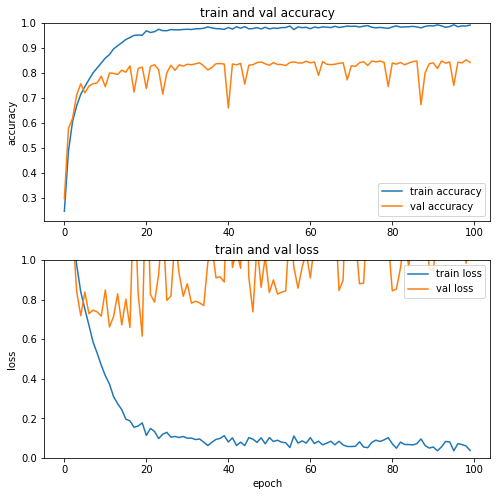

In [0]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='train accuracy')
plt.plot(val_acc, label='val accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('train and val accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend(loc='upper right')
plt.ylabel('loss')
plt.ylim([0, 1.0])
plt.title('train and val loss')
plt.xlabel('epoch')
plt.show()

In [0]:
score = model.evaluate(test_dataset)

10/10 [==============================] - 1s 77ms/step - loss: 1.3550 - sparse_categorical_accuracy: 0.8382


In [0]:
print('Test accuracy : {}'.format(score[1]))

Test accuracy : 0.8381999731063843


In [0]:
model.save_weights(filepath='vgg19/cifar10/1', save_format='tf')

In [0]:
!zip -r vgg19-cifar10.zip vgg19/

  adding: vgg19/ (stored 0%)
  adding: vgg19/cifar10/ (stored 0%)
  adding: vgg19/cifar10/1.index (deflated 77%)
  adding: vgg19/cifar10/1.data-00000-of-00002 (deflated 87%)
  adding: vgg19/cifar10/checkpoint (deflated 34%)
  adding: vgg19/cifar10/1.data-00001-of-00002 (deflated 14%)


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Save Keras Model or weights on google drive

# create on Colab directory
model_file = drive.CreateFile({'title' : 'vgg19-cifar10.zip'})
model_file.SetContentFile('vgg19-cifar10.zip')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1OR1GrZrz5RJWAl3Rx_k7ta_ZEUO1FO3d'})